In [6]:
%matplotlib inline
import os
import glob
import re
import shutil
from collections import Counter
import statistics

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import bokeh.models
import bokeh.plotting as bp #import figure, output_notebook, show
import csv
import itertools
import collections
import networkx as nx
import seaborn as sns
from statsmodels.formula.api import ols



### Arbeitsplan
* Ist die Falkennovelle ein wichtiges Vorbild?
* "Silhouette" im Vergleich zu den Romanen überprüfen -> Isabella
* Gibt es im Novellenschatz Texte, die ein Modell für die anderen Texte darstellen? (Zeitsprung)
* Delta mit Dateinamen, die das Datum enthalten.
* Maschinelles Lernen. Klassifikation. Klassifikation aufgrund der Figurenkonstellation


## Exploration des Novellenschatzes

Der Novellenschatz ist eine Sammlung von Texten, die nicht zuletzt durch ihre Aufnahme in den Novellenschatz als  Novellen kanonisiert wurden. Es stellt sich daher  die Frage, ob die Konstruktionsprinzipien, die dieser Auswahl zugrundeliegen, genauer, das Konzept von Novelle, das die Auswahl steuert und bestimmt, mit Verfahren des distant readings ermittelt werden kann. Meines Erachtens kann man zeigen, warum dies auf dem augenblicklichen Stand der quantitativen Textanalyse problematisch ist. 

In [126]:
#Dateien des Novellenschatzes
files_dir = r"..\..\romankorpus\data\andere Quellen\novellenschatz1\korpus_novellenschatz\gesamt"

#Erzählungen aus dem Textgridkorpus
narr_dir = r"\mydata\owncloud\projekt romangeschichte\Erzählungen\erzaehlungen"

new_meta_data = "novellen.xslx"

### Einige nützliche Klassen und Funktionen

In [127]:
import re
def get_token_nr(file):
    token_nr = 0
    with open(file, encoding="utf-8") as fin:
        for line in fin:
            token_nr += len(re.findall("\w+", line))
    return token_nr

In [128]:
class Text():
    def __init__(self, author, title):
        self.author = author
        self.title = title
        self.year_of_publication = 0
        self.genre = ""
        self.tgid = ""
        self.author_gender = ""
        self.filename = ""
        self.tokens = 0
        
    def __repr__(self):
        return ("{0}: {1} ({3}) {2}. \ntextgrid id: {4}\nfile: {5}".format(self.author, self.title, 
                                                         self.year_of_publication, self.genre, self.tgid, self.filename))  
        
    
t = Text("Willibald Alexis", "Herr von Sacken")
t.genre = "Historischer Roman"
t.author_gender="m"
print(t)

Willibald Alexis: Herr von Sacken (Historischer Roman) 0. 
textgrid id: 
file: 


In [129]:
import glob
import os
data  ={}
for file in glob.glob(files_dir + os.sep + "txt" + os.sep + "*.txt"):
    data[os.path.basename(file)] = get_token_nr(file)
    

### Erster Überblick über den Novellenschatz

In [24]:
import pandas as pd
metadata = pd.read_csv(files_dir + os.sep + "novellen_meta.csv", sep=";")

In [25]:
metadata.head()

,name,title,gender,year
0,Willibald Alexis,Herr von Sacken,masculine,1837
1,Franz Andolt,Eine Nacht,masculine,1858
2,Achim von Arnim,Der tolle Invalide auf dem Fort Ratonneau,masculine,1818
3,Berthold Auerbach,Die Geschichte des Diethelm von Buchenberg,masculine,1853
4,Franz Berthold,Irrwisch Fritze,feminin,1842


In [26]:
meta = metadata[metadata["year"]>0]

[]

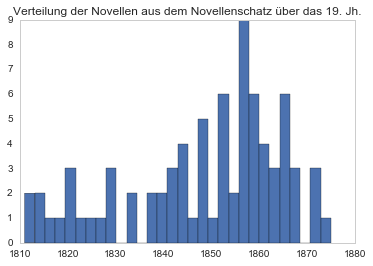

In [27]:
plt.hist(meta.year, bins=30)
plt.title("Verteilung der Novellen aus dem Novellenschatz über das 19. Jh.")
plt.plot()

In [28]:
#Anzahl der Novellen vor 1855
len(meta[meta["year"] < 1855])

41

7

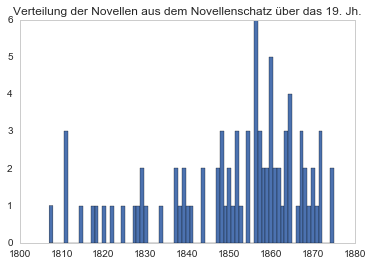

In [29]:
data = pd.read_excel('novellen.xlsx', sheetname='Tabelle2')
plt.hist(data.Jahr, bins=75)
plt.title("Verteilung der Novellen aus dem Novellenschatz über das 19. Jh.")
plt.plot()
len(data[data["Jahr"] < 1820])

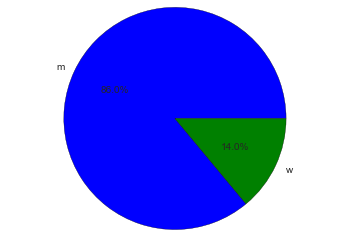

In [30]:
sizes = [len(data.Jahr[data["Geschlecht"]=="m"]), len(data.Jahr[data["Geschlecht"]=="w"])]
labels = ["m","w"]
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
a = plt.axis('equal')

[]

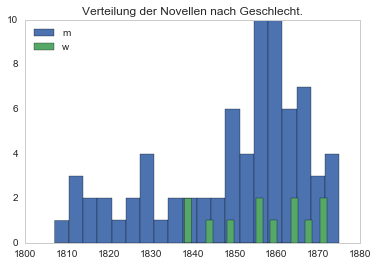

In [31]:
plt.hist(data.Jahr[data["Geschlecht"]=="m"], bins=20, label="m")
plt.hist(data.Jahr[data["Geschlecht"]=="w"], bins=20, label="w")
plt.title("Verteilung der Novellen nach Geschlecht.")
plt.legend(loc='upper left')
plt.plot()


In [32]:
#calculate size of novellas in tokens
sizes = []
for file in glob.glob("corpus" + os.sep + "*.txt"):
    with open(file, encoding="utf-8") as fin:
        sizes.append(len(re.findall("\w+", fin.read())))
        

#### Länge der Novellen

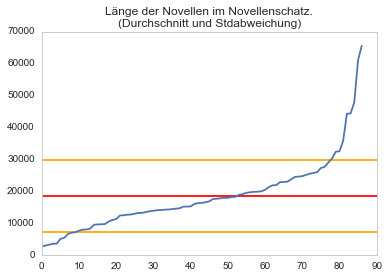

In [33]:
l = sorted(sizes)
plt.title("Länge der Novellen im Novellenschatz.\n(Durchschnitt und Stdabweichung)")
plt.axhline(statistics.mean(l), c="r")
plt.axhline(statistics.mean(l)+statistics.pstdev(l), c="orange")
plt.axhline(statistics.mean(l)-statistics.pstdev(l), c="orange")
plt.plot(l)
plt.savefig("size_novellas.png", dpi=300)
plt.show()

In [34]:
print("Länge der Novellen des Novellenschatzes in Tokens: {}".format(statistics.mean(l)))
print("Stddev in Tokens: {}".format(statistics.pstdev(l)))

Länge der Novellen des Novellenschatzes in Tokens: 18358.850574712644
Stddev in Tokens: 11301.461448092878


#### Länge der Romane

In [35]:
#calculate size of novels in tokens
sizes_r = []
dir_ = r"\daten\Dropbox\uni\Romangeschichte\romankorpus\data"
meta = pd.read_csv(dir_ + os.sep + "romane kernkorpus.csv", encoding="cp1252", sep=";")
novels1 = meta.Datei[meta.Jahr > 1799]  
novels2 = meta.Datei[meta.Jahr < 1901]  
novels = set(novels1).intersection(set(novels2))
for file in novels:
    with open(dir_ + os.sep + "kern_txt" + os.sep + file.replace("__", "_"), encoding="utf-8") as fin:
        sizes_r.append(len(re.findall("\w+", fin.read())))


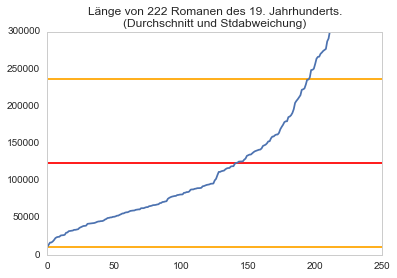

In [36]:
l_r = sorted(sizes_r)
plt.ylim([0, 300000])
plt.title("Länge von {} Romanen des 19. Jahrhunderts.\n(Durchschnitt und Stdabweichung)".format(len(l_r)))
plt.axhline(statistics.mean(l_r), c="r")
plt.axhline(statistics.mean(l_r)+statistics.pstdev(l_r), c="orange")
plt.axhline(statistics.mean(l_r)-statistics.pstdev(l_r), c="orange")
plt.plot(l_r)
plt.savefig("size_novels.png", dpi=300)
plt.show()

In [37]:
print("Länge von Romanen des 19. Jh. in Tokens: {}".format(statistics.mean(l_r)))
print("Stddev von Romanen des 19. Jh. in Tokens: {}".format(statistics.pstdev(l_r)))
len([i for i in l_r if i < 30000])

Länge von Romanen des 19. Jh. in Tokens: 123884.08108108108
Stddev von Romanen des 19. Jh. in Tokens: 112734.0886205301


15

In [38]:
import csv
def get_filename(e, files):
    name, *rest = (e.Autor).split()
    for i in files:
        if name in i:
            return i
    return ""

cnt = 0
tmp = []
files = glob.glob("corpus" + os.sep + "*.txt")
for i in range(len(data)):
    fn = get_filename(data.iloc[i], files)
    tmp.append(os.path.basename(fn))
    cnt += 1

fi = pd.Series(tmp, name="Datei")
data["Datei"] = fi
data.head()
data.to_csv("novellen2.csv", sep=";", encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC)


Gut, nun haben wir eine Metadaten-Datei, in der wir einerseits die Metadaten, aber eben auch die Dateinamen haben, was es uns erlaubt, Analysen der Texte direkt mit den Metadaten zu verbinden.

## Vorbilder finden

Sind die Vorbilder für die Autoren des Novellenschatzes selbst wiederum Teil dieser Sammlung? Ein Text A kann für einen anderen Text B in vielerlei Hinsicht ein Vorbild, ein Modell sein. Das kann für den Stil gelten, für die Charakterisierung oder die Figurenkonstellation, für das Thema, für Aspekte der uneigentlichen Rede, z.B. wie Symbole oder Allegorien gebildet werden, für die Handlung oder Aspekte der Handlung wie die Handlungsstruktur und vieles anderes mehr. Beginnen wir die Untersuchung mit einem einfachen Vergleich des Stils. Die Stilometrie ist eines der ältesten Arbeitsfelder der Digital Humanities und inzwischen auch eines der erfolgreichsten (Stamatos, Juola). Wir verwenden ein Verfahren, das in den letzten Jahren intensiv untersucht wurde und inzwischen recht gut verstanden ist (Burrows, Evert), eine Variation von Burrows Delta. Allerdings zeigt sich sofort, dass die stilistische Ähnlichkeit alleine keine besonders interessanten Aussagen erlaubt: 

<img src="Stylistic analysis using Delta-3000 mfw. COSINE_DELTA-2017-2-4-13-4.png" width="1300" >

Erwartungsgemäß werden die Texte eines Autors zusammen gruppiert, aber ansonsten zeigen sich so keine auffälligen Gruppenbildungen. Im Folgenden verwenden wir eine Graphen-Präsentation, um die Distanzmatrix zu visualisieren:

In [43]:
import networkx as nx
import pandas as pd
data = pd.read_csv("delta_dm.csv", sep=",", index_col=0, encoding="utf-8")

Wir filtern die Kanten weg, die einen größeren Abstand haben. Ein 'größerer Abstand' liegt dann vor, wenn die Differenz zwischen der fokussierten Distanz und dem Mittelwert größer ist als die Standardabweichung.

0.9995996024777564


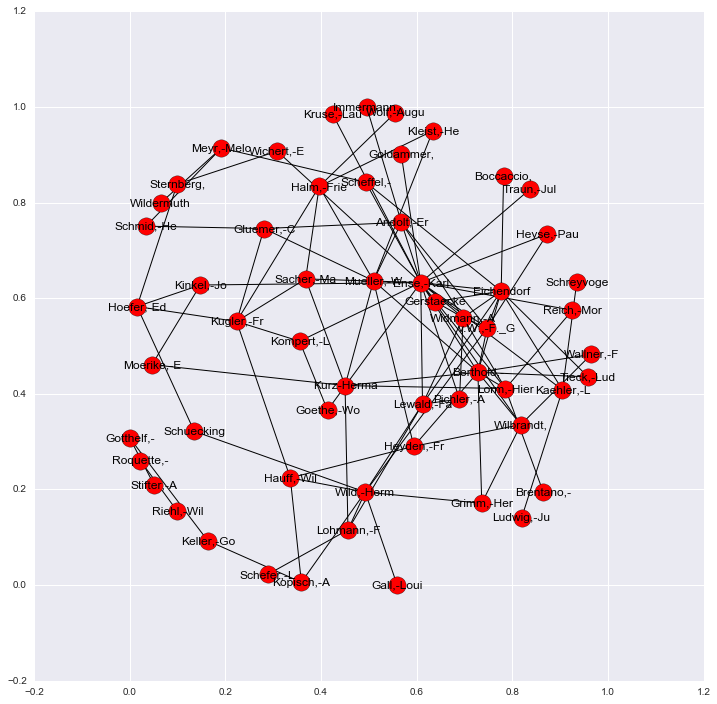

In [48]:
stdev = data.stack().std() 
mean_ = data.stack().mean()
print(mean_)
G = nx.Graph()
factor = 1
for i in data.columns:
    for j in data.index:
        if data[i][j] != 0:
            if abs(data[i][j]-mean_) > factor*stdev : 
                #print("{}-{}: {} ({}>{})".format(i, j, data[i][j], abs(data[i][j]-mean_), factor*stdev))
                G.add_weighted_edges_from([(i[:10], j[:10], data[i][j])])

pos=nx.spring_layout(G)
plt.figure(figsize=(12,12))
nx.draw_networkx(G, pos)

Nun können wir mit Netzwerkmaßen die 'wichtigsten' Knoten identifizieren:

In [42]:
deg = nx.degree(G)
degc = collections.Counter(deg)
degc.most_common(5)

[('Ense,-Karl', 21),
 ('Berthold,-', 11),
 ('Eichendorf', 10),
 ('Widmann,-A', 8),
 ('Wild,-Herm', 8)]

In [39]:
import shutil
meta = pd.read_excel("novellen2.xlsx")
for i in list(meta.Datei):
    author, *title = i.split("_")
    lastname, *firstname = author.split(",-")
    year = (meta.Jahr[meta.Datei == i]).item()
    new_ = "{}_{}({}).txt".format(lastname, title[0][:10], year) 
    shutil.copy("corpus" + os.sep + i, "corpus3" + os.sep + new_)
    

Also müssen wir die Frage vielleicht anders stellen. Was uns eigentlich interessiert, ist ja eine besondere Nähe eines Textes B zu einem früher entstandenen Text A. Was aber heißt hier 'besondere Nähe'? Um das zu klären, müssen wir etwas ausholen. Aus anderen Verwendungen von Burrows Delta ist es klar, dass zumindest drei Aspekte die stilistische Nähe, die durch das Maß ausgedrückt wird, beeinflussen: Autorschaft, Zeit und Gattung. Da die meisten Texte von unterschiedlichen Autoren sind, fällt dies hier nicht ins Gewicht. Angeblich gehören alle Texte der gleichen Gattung an. Also sollte sich hier besonders der Faktor Zeit bemerkbar machen. Unsere Grundannahme kann daher lauten, dass die Texte, die einem Text B nach Delta besonders ähnlich sind, die Texte der (ungefähr) gleichen Zeit sind. Eine 'besondere', d.h. eine auffällige Nähe würde also dann vorliegen, wenn A stilistisch näher zu B liegt, <b>obwohl</b> der zeitliche Abstand größer ist. Anders ausgedrückt: Wenn der Autor eines Textes B kein stilistisches Vorbild hat, dann wird seine Sprache vor allem eine besondere Nähe zu der der Zeitgenossen aufweisen. Wenn er dagegen ein stilistisches Vorbild hat, dann wird sich dieses Vorbild gegen den Einfluss der zeitgenössischen Sprache durchsetzen. Natürlich gibt es auch die Möglichkeit, dass ein Autor einen Zeitgenossen als stilistisches Vorbild hat, aber das lässt sich nur schwer nachweisen, da schon die zeitliche Nähe eine stilistische Nähe bringt und sich die  Nähe bislang nur schwer so quantifizieren lässt, dass sie argumentativ nutzbar wäre.    
Daraus ergibt sich dann der Grundzug eines Versuchsaufbaus: Ermittle aufgrund der Distanzmatrix von Delta für jeden Text die 5 nächsten Nachbarn. Das wären dann die stilistisch ähnlichsten Texte. Die Zahl fünf ist hierbei willkürlich gewählt. Im nächsten Schritt werden dann jeweils die Texte angezeigt, die zeitlich deutlich früher liegen. "deutlich früher" muss noch operationalisiert werden. Dazu könnte man nun eine anspruchsvollere Metrik verwenden, die einen größeren Abstand höher gewichtet oder die den mittleren Abstand aller Texte als Bezugspunkt nimmt und alles jenseits einer Standardabweichung als auffällig markiert, aber auch hier beginnen wir erst einmal ganz einfach und verwenden einen einfachen Schwellenwert, nämlich 10 Jahre. Vielleicht sollte man noch hervorheben, dass die Beziehungen nicht symmetrisch sind, d.h. obwohl das Delta-Maß symmetrisch ist, interessieren uns für die Suche nach Vorbildern nur die zeitlich vorangehenden Texte. Wenn also ein untersuchter Text seine nächsten Nachbarn nur in den später geschriebenen Texten hat, dann ist er evtl. selbst ein Vorbild, hat aber keines, zumindest keines im Novellenschatz. 
Das Ergebnis dieser Versuchsanordnung fällt überraschend informativ aus, besonders da die Liste der ersten 5-6 Texte relativ stabil bleibt, selbst wenn man den Abstand vom untersuchten Text zu den Vorbildern von 10 auf 15 Jahre vergrößert. Hier das Ergebnis mit 10 Jahren:

In [40]:
metadata = pd.read_excel("novellen2.xlsx")
#print(metadata.head(10))
deltas = pd.read_csv("Stilistische Ähnlichkeit der Texte im Novellenschatz-3000 mfw. const.COSINE_DELTA.results.csv", 
                     sep=",", index_col=0)
#deltas.head()

def historical_distance(text, neighbours):
    models_tmp = Counter()
    year_of_publication = (metadata.Jahr[metadata.Datei == text]).item()
    for i in neighbours.index:
        n = metadata.Jahr[metadata.Datei == i]
        
        if len(n) == 1:
            n = n.item()
            if year_of_publication - n > 10:
                #print("text: {}({}) - modell: {}({})".format(text, year_of_publication, i, n))
                models_tmp[i] += 1
        else: 
            print("###" + text)
    
    return models_tmp


models = Counter()
for c in deltas.index:
    dist = deltas[c].sort_values()
    nearest_neighbours = dist[1:5] 
    models += historical_distance(c, nearest_neighbours)

for i in models.most_common(20):
    print("{} - {} ({})".format(i[1], i[0], (metadata.Jahr[metadata.Datei == i[0]]).item()))

12 - Eichendorff,-Joseph-von_Die-Gluecksritter.txt (1840)
10 - Ense,-Karl-August-Varnhagen-von_Reiz-und-Liebe.txt (1815)
6 - Mueller,-Wilhelm_Debora.txt (1828)
6 - Berthold,-Franz_Irrwisch_Fritze.txt (1839)
5 - v.W.,-F._Gemüth-und-Selbstsucht.txt (1838)
5 - Tieck,-Ludwig_Die-Gemaelde.txt (1822)
4 - Goethe,-Wolfgang-von_Die-neue-Melusine.txt (1807)
3 - Alexis,-Willibald_Herr-von-Sacken.txt (1837)
3 - Hauff,-Wilhelm_Phantasien-im-Bremer-Ratskeller.txt (1827)
3 - Kaehler,-Ludwig-August_Die-drei-Schwestern.txt (1811)
2 - Brentano,-Clemens_Geschichte-vom-braven-Kasperl-und-dem-schoenen-Annerl.txt (1817)
2 - Lohmann,-Friederike_Die-Entscheidung-bei-Hochkirch.txt (1844)
2 - Kugler,-Franz_Die-Incantada.txt (1852)
2 - Hoffmann,-E.T.A._Das-Fraeulein-von-Scuderi.txt (1820)
2 - Meyr,-Melchior_Der-Sieg-des-Schwachen.txt (1861)
2 - Spindler,-Karl_Die-Engel-Ehe.txt (1844)
2 - Kompert,-Leopold_Eine-Verlorene.txt (1851)
2 - Kleist,-Heinrich-von_Die-Verlobung-von-St-Domingo.txt (1811)
2 - Schreyvogel,-J

Überraschenderweise stammt der wichtigste Bezugstext von Eichendorff, wobei man annehmen darf, dass in diesem Kontext der spezifische Text weniger wichtig ist als die Autorschaft. Vielleicht noch überraschender ist die Relevanz des Textes von Varnhagens, der heute eher durch seine Erinnerungstexte bekannt ist. Schon deutlich weniger häufig sind die folgenden Bezüge, wobei wir, da uns Autoren mehr interessieren als Einzeltexten, die beiden Referenzen auf Tieck zusammenfassen, so das er zum drittwichtigsten Bezugsautor wird - eine Einschätzung, die in dieser allgemeinen Form von der Novellenforschung geteilt wird (Neumann 2015).  
Nun gibt es allerdings ein Problem, nämlich dass einige der untersuchten Texte nicht nur ein oder zwei, sondern sogar drei solche unwahrscheinlichen stilistischen Vorbilder haben. Das spricht dafür, dass diese Texte wohl keines der 'Vorbilder' wirklich als Vorbild hat, sondern einfach eine besondere Nähe zu dieser früheren stilistischen Stufe hat. Grillparzer ist ein Beispiel dafür. Das ist zwar in sich interessant, aber in diesem Untersuchungszusammenhang nicht relevant. Hier interessieren uns ja die Texte als spezifische Vorbilder und nicht als Repräsentanten einer früheren Sprachstufe. Im folgenden werden also die Vorbilder entfernt, die für Texte mit drei oder mehr Vorbildern in Erscheinung treten. Das interessante Ergebnis sieht so aus: 

In [41]:
def historical_distance(text, neighbours):
    models_tmp = Counter()
    year_of_publication = (metadata.Jahr[metadata.Datei == text]).item()
    for i in neighbours.index:
        n = metadata.Jahr[metadata.Datei == i]
        
        if len(n) == 1:
            n = n.item()
            if year_of_publication - n > 10:
                #print("text: {}({}) - modell: {}({})".format(text, year_of_publication, i, n))
                models_tmp[i] += 1
        else: 
            print("###" + text)
    
    if len(models_tmp) > 2 :
        return Counter()
    else:
        return models_tmp


models = Counter()
for c in deltas.index:
    dist = deltas[c].sort_values()
    nearest_neighbours = dist[1:5] 
    models += historical_distance(c, nearest_neighbours)

for i in models.most_common(20):
    print("{} - {} ({})".format(i[1], i[0], (metadata.Jahr[metadata.Datei == i[0]]).item()))

10 - Eichendorff,-Joseph-von_Die-Gluecksritter.txt (1840)
6 - Ense,-Karl-August-Varnhagen-von_Reiz-und-Liebe.txt (1815)
5 - Berthold,-Franz_Irrwisch_Fritze.txt (1839)
4 - Mueller,-Wilhelm_Debora.txt (1828)
3 - Alexis,-Willibald_Herr-von-Sacken.txt (1837)
3 - Tieck,-Ludwig_Die-Gemaelde.txt (1822)
2 - Auerbach,-Berthold_Die-Geschichte-des-Diethelm-von-Buchenberg.txt (1853)
2 - Brentano,-Clemens_Geschichte-vom-braven-Kasperl-und-dem-schoenen-Annerl.txt (1817)
2 - Goethe,-Wolfgang-von_Die-neue-Melusine.txt (1807)
2 - Hauff,-Wilhelm_Phantasien-im-Bremer-Ratskeller.txt (1827)
1 - Schuecking,-Levin_Die-Schwester.txt (1848)
1 - Tieck,-Ludwig_Des-Lebens-Ueberfluss.txt (1839)
1 - Kinkel,-Johanna_Musikalische-Orthodoxie.txt (1849)
1 - Zschokke,-Heinrich_Der-todte-Gast.txt (1825)
1 - Grillparzer,-Franz_Der-arme-Spielmann.txt (1848)
1 - Hoffmann,-E.T.A._Das-Fraeulein-von-Scuderi.txt (1820)
1 - Spindler,-Karl_Die-Engel-Ehe.txt (1844)
1 - Kinkel,-Gottfried_Margret.txt (1847)
1 - Rumohr,-Karl-Friedric

Die Liste der ersten 5 Namen ist fast gleich geblieben. Das heißt, diese Texte sind offensichtlich als spezifische Texte relevant bzw. sind die Autoren Vorbilder. Aber ein Text ist ganz aus der Liste verschwunden, v.W.,-F._Gemüth-und-Selbstsucht.txt (1838). Dieser Text, so kann wohl schlussfolgern, hat tatsächlich keine spezifische Vorbildfunktion, sondern wurde nur zufällig als Repräsentant einer früheren Sprachstufe aufgeführt. 

Schauen wir uns die Liste genauer an....

Wie verhält es sich nun mit den Texten, die diese hier als Vorbilder haben? Wie verteilen sie sich über die Jahre. Gibt es etwa eine identifizierbare Zeitspanne, in der Tieck ein Modell ist? .... 

Für die weiteren Analysen wird der Novellenschatz präprozessiert und eine Reihe von linguistischen Merkmalen erhoben: POS, Morphologie, Lemma, Named Entity, Koreferenz. Das hier verwendete Werkzeug wurde im Rahmen des Projekts Kallimachos von Markus Krug entwickelt und in einer Reihe von Aufsätzen beschrieben (Jannidis 2015, Krug 2016). 

In [ ]:
#def analyze_text(text):
    
    


### main loop ###    
for file in glob.glob("data" + os.sep + "*.csv"):
    text = pd.read_csv(file, sep="\t", encoding="cp1250", index_col=False)

text.iloc[0]    

In [ ]:
names = text[(text.NamedEntity == "B-PER_CORE") | (text.NamedEntity == "I-PER_CORE")]

## Die Falkennovelle als Modell?

Paul Heyse verwendet die Beschreibung des Inhalts der Falkennovelle von Boccaccio als Modell für eine klare Silhoutte. Gemeint ist damit offensichtlich so etwas wie eine klare Handlungsführung - was immer damit genau gemeint ist. Nun stellt sich das Problem, dass gerade die Handlung etwas ist, was kaum brauchbar modelliert werden kann. Die von Jockers angeregte Methode, den sentiment-Verlauf zu nehmen, zeigt weniger den Handlungsverlauf als die Emotionen der verwendeten Worte. Es ist doch recht fraglich, ob dies ein brauchbarer Stellvertreter für Plot ist. 
Aber selbst wenn es möglich wäre, so etwas wie die Ähnlichkeit des Handlungsverlaufs zu ermitteln, so bezieht sich Heyse ja nur auf ein Merkmal dieses Handlungsverlauf, die klare Kontur. Er operationalisiert dieses Merkmal als  die Möglichkeit eine gute Zusammenfassung der wesentlichen Handlungselemente in wenigen Sätzen zu leisten. Das ist eine Eigenschaft der Handlung. Kann man diese Eigenschaft mit den Verfahren der quantitativen Analyse ermitteln und so die Texte im Novellenschatz von anderen Texten unterscheiden, die diese Eigenschaft nicht oder weniger haben?



Beginnen wir mit der einfachen Frage, ob die Falkennovelle eine besondere Rolle für die Texte spielt, die im Novellenschatz ausgewählt wurden. Ist sie ein Modell für die Texte, die ausgewählt wurden. Wiederum stellt sich die Frage, für welchen Aspekt eines Erzähltextes die Novelle ein Modell sein könnte. Beginnen wir mit einem einfachten Vergleich auf der Grundlage des Stils, den wir generisch mit Burrows Delta erfassen, genauer mit einer Variation aufgrund des Kosinus zwischen den Wortvektoren, die sich als robuster und treffsicherer erwiesen hat (Jannidis et.al. 2015, Evert et.al. 2016). 
Allerdings kann die Anwendung eines Distanzmasses allein die Frage nicht beantworten. 

## Figurenanalyse

Kann man einen unterschiedlichen Plotverlauf über die Figurenkonstellation erkennen? 
3 Versuche: 
* 
* das durchschnittliche prozentuale Vorkommen der häufigsten Figuren
* Centrality Degree für den Text. Müsste eigentlich bei Novellen eine Bevorzugung des Sternnetzwerks zeigen.


In [9]:
def get_relations(corefs):
    """retrieve character references from list of corefs per para"""
    corefs = corefs[corefs != -1]  #drop -1 as node value
    entities = sorted(set(corefs))
    return itertools.combinations(entities, 2)
    
def count_relations(relations):
    cnt = collections.Counter()
    for i in relations:
        cnt[i] += 1
    return cnt

def fix_table(df):
    """Fix for Markus' table bug"""
    df.ParagraphId = pd.to_numeric(data.ParagraphId , errors='coerce')
    df.CorefId = pd.to_numeric(data.CorefId , errors='coerce')
    df.ParagraphId = data.ParagraphId.fillna(max(data.ParagraphId)+1)
    df.CorefId = df.CorefId.fillna(-1) 
    return df


def group_degree_centrality(g):
    """calculates degree centrality for the whole network
       measure proposed by L. Freeman 
       returns 1.0 for a star network, 0.0 for a ring network, and 0.067 for a line
    """
    nodes = nx.degree_centrality(g)
    degrees = pd.Series(list(nodes.values()))
    n = len(degrees)
    degrees = degrees * (n-1)  #reverse the normalization
    sum_deg = 0

    for node_degree in degrees:
        sum_deg+= max(degrees) - node_degree
    return sum_deg / (n**2-3*n+2)


        

In [112]:
group_degree_centralities = []
for infile in glob.glob("data" + os.sep + "*.csv"):
    data = pd.read_table(infile, 
                         encoding="cp1252", 
                         index_col=False, 
                         quoting=csv.QUOTE_NONE,
                         na_values=["-","null"],
                        )
    data = fix_table(data)  #bug fixing
    data = data[data.NamedEntity != "B-PER_PRON"]  #remove the personal pronouns
    rel_count = collections.Counter()
    for i in range(int(max(data.ParagraphId))):
        corefs = data.CorefId[data.ParagraphId == i]
        relations = get_relations(corefs)
        rel_count += count_relations(relations)

    G = nx.Graph(name = os.path.basename(infile))
    for edge in rel_count.most_common(20):
        G.add_edge(edge[0][0], edge[0][1], weigth=edge[1])
    group_degree_centralities.append(group_degree_centrality(G)) 
    


In [113]:
len([i for i in group_degree_centralities if i > 0.5]) / len(group_degree_centralities)

0.6666666666666666

Vergleichen wir diese Daten  mit der Verteilung in den Romanen:

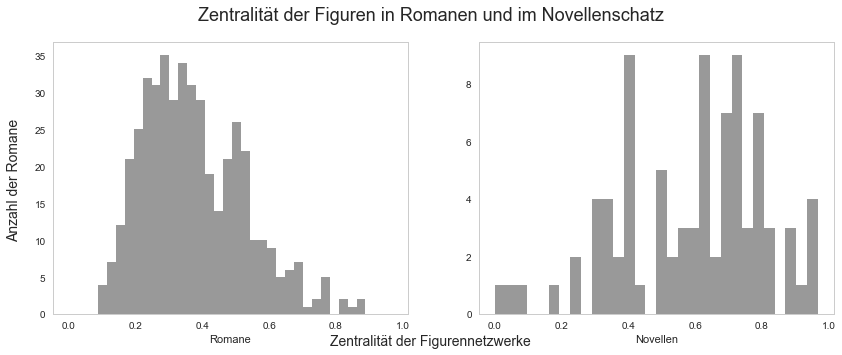

In [119]:
#reading data from novels
cd_g_all = pd.read_csv("..\\figuren\\graph_degree_centrality.csv", sep = ";", index_col=0, 
                       header=None, names=["values"], skiprows=1)

#plotting
sns.set_style("whitegrid", {'axes.grid' : False})
f, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)
f.suptitle("Zentralität der Figuren in Romanen und im Novellenschatz", fontsize=18)
g  = sns.distplot(sorted(cd_g_all.values), bins=30, kde=False, ax=axes[0], color="black")
g.set_xlabel("Romane")
h = sns.distplot(sorted(group_degree_centralities), bins=30, hist=True, kde=False, ax=axes[1], color="black")
h.set_xlabel("Novellen")
f.text(0.5, 0.04, 'Zentralität der Figurennetzwerke', ha='center', fontsize=14)
f.text(0.08, 0.5, 'Anzahl der Romane', va='center', fontsize=14, rotation='vertical')
f.savefig("zentralitaet.png", dpi=1200)




In [5]:
import scipy
scipy.stats.ttest_ind(cd_g_all.values, group_degree_centralities, axis=0, equal_var=False)

Ttest_indResult(statistic=array([-8.75432209]), pvalue=array([  4.29000131e-14]))

Wenn man einen zweiseitigen t-test nach Welch über die Daten macht, bestätigt das den Augenschein: Die Daten sind mit sehr hoher Wahrscheinlichkeit nicht aus derselben Verteilung (4.29e-14). 

In [39]:
cd_g_novels = cd_g_all.values
cdgs = []
for i in cd_g_novels:
    cdgs.append(i.item())
len([i for i in cdgs if i > 0.5]) / len(cdgs)

0.21460176991150443

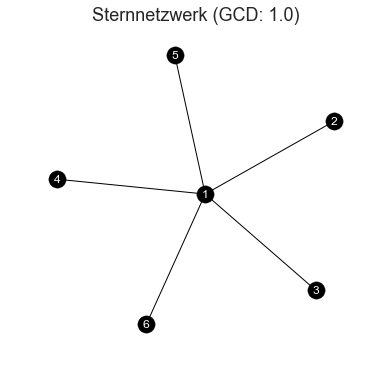

In [98]:
sns.set_style("white")
fig = plt.figure(figsize=(6,6))

G = nx.Graph()
G.add_edges_from([(1,2),(1,3),(1,4),(1,5),(1,6)])
plt.title("Sternnetzwerk (GCD: {})".format(group_degree_centrality(G)),  fontsize=18)
#sns.set_style("whitegrid", {'axes.grid' : False})
#sns.despine( left=True, bottom=True, trim=True)
plt.axis("off")
nx.draw_networkx(G, node_color="black", font_color="white")
#plt.savefig("abbildung_3.png", dpi=1200)


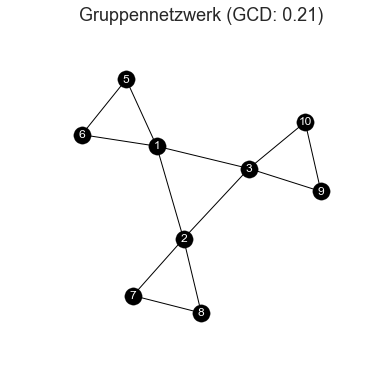

In [64]:
plt.figure(figsize=(6,6))
sns.set_style("white")
G = nx.Graph()
G.add_edges_from([(1,2),(1,3),(2,3),(1,5),(1,6),(5,6),(2,7), (2,8), (7,8), (3,9), (3, 10), (9,10)])
plt.title("Gruppennetzwerk (GCD: {})".format(round(group_degree_centrality(G), 2)), fontsize=18)
plt.axis("off")
nx.draw_networkx(G, node_color="black", font_color="white")
plt.savefig("network_group.png", dpi=1200)

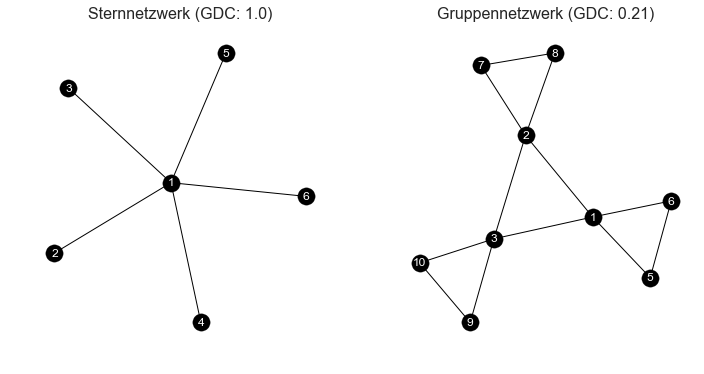

In [110]:
#create data / graphs
G = nx.Graph()
G.add_edges_from([(1,2),(1,3),(1,4),(1,5),(1,6)])
G2 = nx.Graph()
G2.add_edges_from([(1,2),(1,3),(2,3),(1,5),(1,6),(5,6),(2,7), (2,8), (7,8), (3,9), (3, 10), (9,10)])


#plotting
sns.set_style("white")
fig = plt.figure(figsize=(12,6))

ax = fig.add_subplot(1, 2, 1)
plt.title("Sternnetzwerk (GDC: {})".format(group_degree_centrality(G)),  fontsize=16)
plt.axis("off")
nx.draw_networkx(G, ax=ax, node_color="black", font_color="white")

ax = fig.add_subplot(1, 2, 2)
plt.title("Gruppennetzwerk (GDC: {})".format(round(group_degree_centrality(G2), 2)), fontsize=16)
plt.axis("off")
nx.draw_networkx(G2, ax=ax, node_color="black", font_color="white")
plt.savefig("network_GDC_examples.png", dpi=1200)
plt.show()


### Das durchschnittliche prozentuale Vorkommen der häufigsten Figuren (Beitrag Isabella Reger)
Geplottet wurde das durchschnittliche prozentuale Vorkommen der häufigsten Figuren. Auf der x-Achse sind die Stufen des Häufigkeitsrankings (1=häufigste Figur, 2 = zweithäufigste F., usw), auf der y-Achse der durchschnittliche prozentuale Anteil dieser Figur an allen Figurenreferenzen im Text, über alle Texte hinweg. Daraus ergibt sich eine Kurve, die der Zipfschen Verteilung ähnelt. Unter der Annahme, dass Novellen einen geradlinigeren Handlungsverlauf (bspw. keine/weniger Nebenschauplätze oä) aufweisen als Romane, müssten sie weniger Nebenfiguren und wahrsch. auch insg. weniger Figuren enthalten, auch wenn man die andere Länge der Text mitveranschlagt. Die Erwartung wäre also, dass die Kurve für Novellen steiler abfällt und schneller gegen 0 geht als bei Romanen. Wenn man den Plot betrachtet, kann man das jedoch nicht beobachten.
<img src="reger_plot_counts.png">

## Exkurs PCA testen
Romane von Goethe, Fontane und Raabe als Testfall für PCA

[-2.68420713 -2.71539062 -2.88981954 -2.7464372  -2.72859298 -2.27989736
 -2.82089068 -2.62648199 -2.88795857 -2.67384469 -2.50652679 -2.61314272
 -2.78743398 -3.22520045 -2.64354322 -2.38386932 -2.6225262  -2.64832273
 -2.19907796 -2.58734619 -2.3105317  -2.54323491 -3.21585769 -2.30312854
 -2.35617109 -2.50791723 -2.469056   -2.56239095 -2.63982127 -2.63284791
 -2.58846205 -2.41007734 -2.64763667 -2.59715948 -2.67384469 -2.86699985
 -2.62522846 -2.67384469 -2.98184266 -2.59032303 -2.77013891 -2.85221108
 -2.99829644 -2.4055141  -2.20883295 -2.71566519 -2.53757337 -2.8403213
 -2.54268576 -2.70391231]
<class 'numpy.ndarray'>
(150, 2)
<class 'numpy.ndarray'>
explained variance ratio (first two components): [ 0.92461621  0.05301557]


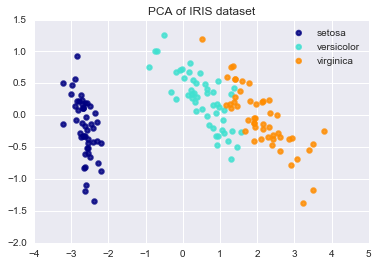

In [106]:
from sklearn import datasets
from sklearn.decomposition import PCA

iris = datasets.load_iris()

X = iris.data
y = iris.target
target_names = iris.target_names

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)
print(X_r[y == 0, 0])
print(type(X_r))
print(X_r.shape)
print(type(y))
# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))


plt.figure()
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of IRIS dataset')

plt.show()

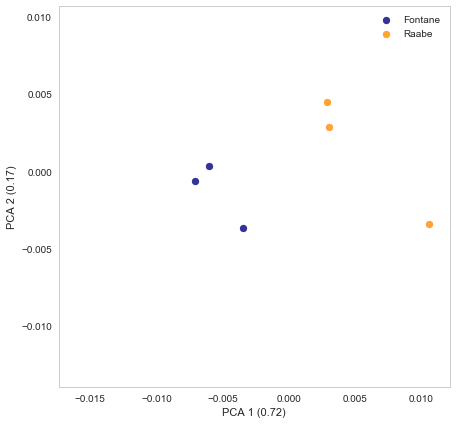

In [63]:
data = pd.read_csv("corpus_words_simple.csv", index_col=0)[0:10].T

y = np.array([0 if n[0:5]=="Fonta" else 1 for n in data.index])

pca = PCA(n_components=2).fit(data)
X_r = pca.transform(data)

plt.figure( figsize =( 7, 7)) 
colors = ['navy', 'darkorange']
labels = ["Fontane", "Raabe"]

for (i, color, label) in zip([0, 1], colors, labels):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, label=label)  

plt.xlabel("PCA 1 ({:.2f})".format(pca.explained_variance_ratio_[0].item()))
plt.ylabel("PCA 2 ({:.2f})".format(pca.explained_variance_ratio_[1].item()))
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.show()

## Novellenschatz - Gruppenbildung?

Zeigen sich innerhalb der Texte des Novellenschatzes auffällige Gruppenbildungen? Untersuchen wir erst einmal nach die Unterschiede aufgrund der Entstehungszeit:

In [121]:
now = 100
data = pd.read_csv("corpus_words.csv", index_col=0)[0:now].T
metadata = pd.read_excel("novellen2.xlsx")
mfw_novellas = data.columns


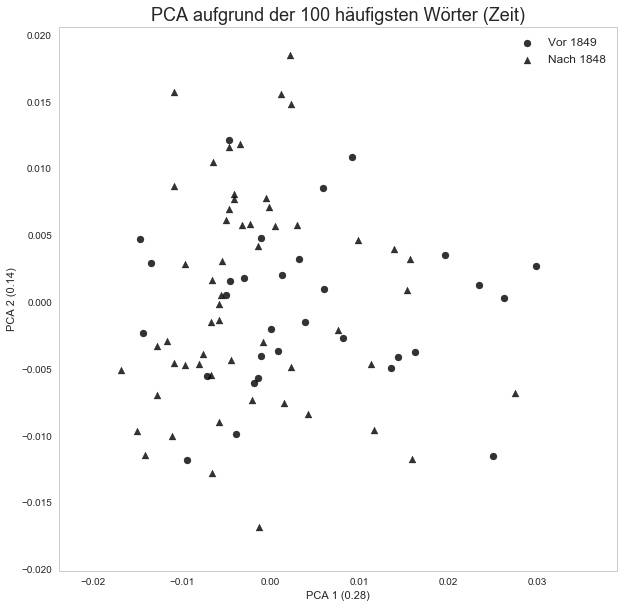

In [122]:

y = []
for i in data.index:
    if (metadata.Jahr[metadata.Datei == i]).item() < 1849: 
        y.append(0)
    else:
        y.append(1)
y = np.array(y)
        
        
pca = PCA(n_components=2).fit(data)
X_r = pca.transform(data)

sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure( figsize =( 10, 10)) 

#colors = ['navy', 'darkorange']
labels = ["Vor 1849", "Nach 1848"]
marker_ = ["o", "^"]


for (i, label, marker) in zip([0, 1], labels, marker_):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color="black", alpha=.8, label=label, marker=marker)  


plt.xlabel("PCA 1 ({:.2f})".format(pca.explained_variance_ratio_[0].item()))
plt.ylabel("PCA 2 ({:.2f})".format(pca.explained_variance_ratio_[1].item()))
plt.legend(loc='best', shadow=False, scatterpoints=1, fontsize=12)
plt.title("PCA aufgrund der {} häufigsten Wörter (Zeit)".format(now), fontsize=18)
plt.savefig("pca_zeit.png", dpi=1200)
plt.show()



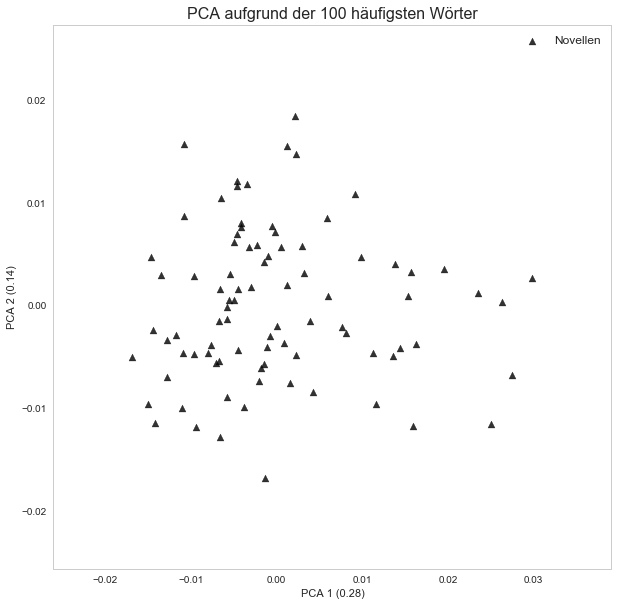

In [124]:
sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure( figsize =( 10, 10)) 

#colors = ['navy', 'darkorange']
marker_ = ["^"]
label = "Novellen"

plt.scatter(X_r[:, 0], X_r[:, 1], color="black", alpha=.8, label=label, marker=marker_[0])  


plt.xlabel("PCA 1 ({:.2f})".format(pca.explained_variance_ratio_[0].item()))
plt.ylabel("PCA 2 ({:.2f})".format(pca.explained_variance_ratio_[1].item()))
plt.legend(loc='best', shadow=False, scatterpoints=1, fontsize=12)
plt.title("PCA aufgrund der {} häufigsten Wörter".format(now), fontsize=16)
plt.savefig("pca_generic.png", dpi=1200)
plt.show()



Die erste Hauptkomponente kann  nur 30% der Varianz erklären. Das ist nicht besonders erklärungsmächtig. Außerdem sieht die Verteilung nicht so aus, als wäre Zeit hier ein relevanter Faktor. Gehen wir sicher und bilden vier Gruppen:

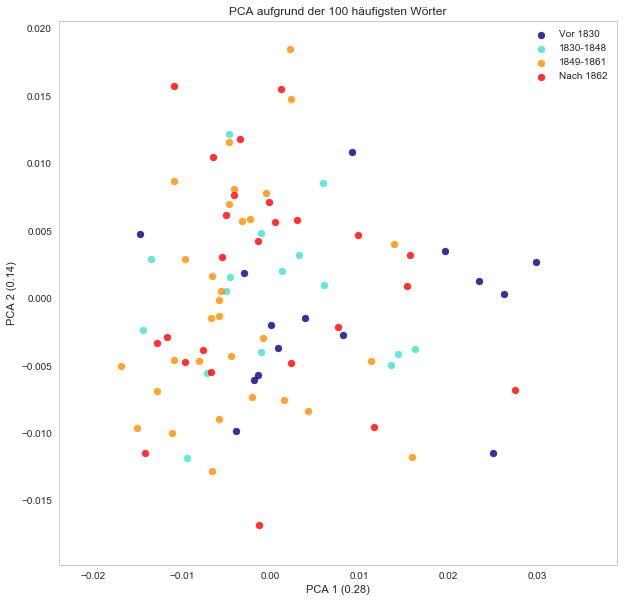

In [54]:
y = []
for i in data.index:
    if (metadata.Jahr[metadata.Datei == i]).item() < 1830: 
        y.append(0)
    elif (metadata.Jahr[metadata.Datei == i]).item() < 1849:
        y.append(1)
    elif (metadata.Jahr[metadata.Datei == i]).item() < 1862:
        y.append(2)
    else:
        y.append(3)
y = np.array(y)
        

plt.figure( figsize =( 10, 10)) 

colors = ['navy', 'turquoise','darkorange', 'red']
labels = ["Vor 1830", "1830-1848", "1849-1861", "Nach 1862"]
marker_ = ["o", "^"]


for (i, label, marker) in zip([0, 1, 2, 3], colors, labels, marker_):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color="black", alpha=.8, label=label, marker=marker)  


plt.title("PCA aufgrund der {} häufigsten Wörter".format(now))
plt.xlabel("PCA 1 ({:.2f})".format(pca.explained_variance_ratio_[0].item()))
plt.ylabel("PCA 2 ({:.2f})".format(pca.explained_variance_ratio_[1].item()))
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.show()
    

Stellt sich die Frage, ob die Kanonisierung der Texte in der Verteilung niederschlägt? Sieht nicht so aus:

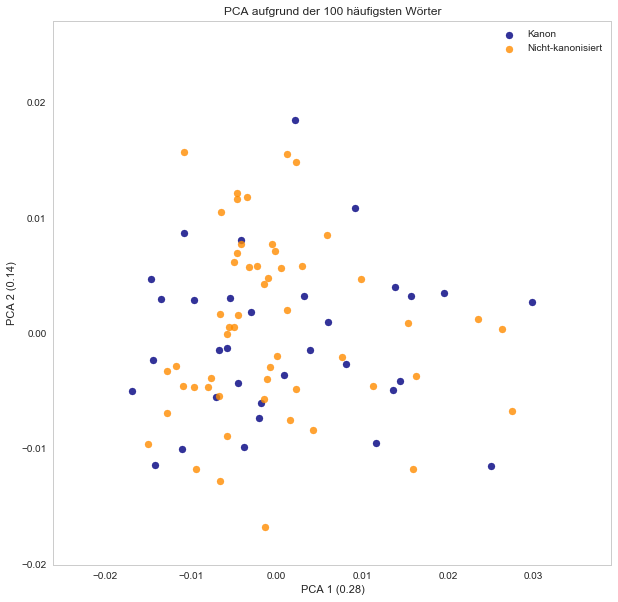

In [55]:
y = []
for i in data.index:
    if (metadata.Kanon[metadata.Datei == i]).item() == "j": 
        y.append(0)
    else:
        y.append(1)
y = np.array(y)
      

plt.figure( figsize =( 10, 10)) 

colors = ['navy', 'darkorange']
labels = ["Kanon", "Nicht-kanonisiert"]


for (i, color, label) in zip([0, 1, 2, 3], colors, labels):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, label=label)  


plt.title("PCA aufgrund der {} häufigsten Wörter".format(now))
plt.xlabel("PCA 1 ({:.2f})".format(pca.explained_variance_ratio_[0].item()))
plt.ylabel("PCA 2 ({:.2f})".format(pca.explained_variance_ratio_[1].item()))
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.show()
    

Da die Geschlechterverteilung sich als so ungleich erwiesen hat, könnten geschlechtsspezifische Schreibstile hier eine verborgene Rolle spielen. 

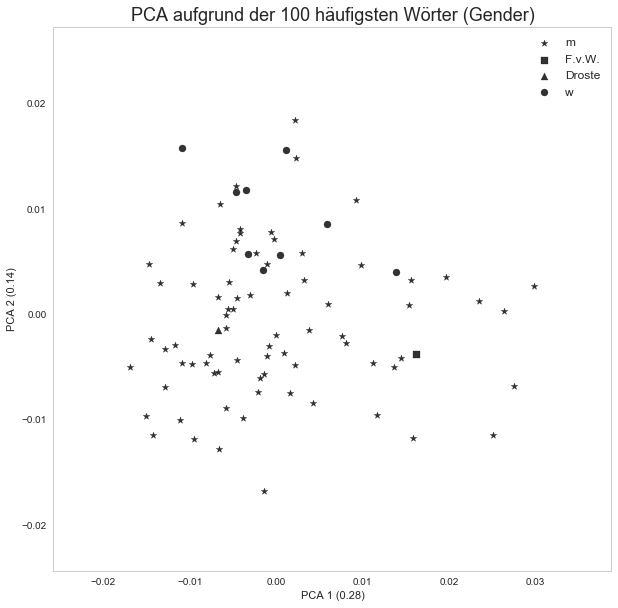

In [70]:
sns.set_style("whitegrid", {'axes.grid' : False})
y = []
for i in data.index:
    if (metadata.Geschlecht[metadata.Datei == i]).item() == "m": 
        y.append(0)
    else:
        if i == "v.W.,-F._Gemüth-und-Selbstsucht.txt":
            y.append(1)
        elif i == "Droste-Huelshoff,-Annette-von_Die-Judenbuche.txt":
            y.append(2)
        else:
            y.append(3)
y = np.array(y)
      

plt.figure( figsize =( 10, 10)) 

colors = ['navy','red', 'green', 'darkorange']
labels = ["m", "F.v.W.", "Droste", "w"]
marker_ = ["*", "s", "^", "o"]


for (i, label, marker) in zip([0, 1, 2, 3], labels, marker_):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color="black", alpha=.8, label=label, marker=marker)  


plt.title("PCA aufgrund der {} häufigsten Wörter (Gender)".format(now), fontsize=18)
plt.xlabel("PCA 1 ({:.2f})".format(pca.explained_variance_ratio_[0].item()))
plt.ylabel("PCA 2 ({:.2f})".format(pca.explained_variance_ratio_[1].item()))
plt.legend(loc='best', shadow=False, scatterpoints=1, fontsize=12)
plt.savefig("pca_gender.png", dpi=1200)
plt.show()
    

Das Bild stellt eine sogenannte Hauptkomponentenanalyse der Texte des Novellenschatzes von Heyse/Kurz aufgrund der 100 häufigsten Wörter dar. Dargestellt wird die Verteilung von zwei Hauptkomponenten. Man muss solche Analysen wiederum inhaltlich deuten, d.h. die Datenanalyse kann einem nicht sagen, welche realweltlichen Faktoren dahinter stecken. Gelesen wird das sozusagen von den zwei Nullpunkten auf der x und y-Achse aus. Habe keine Ahnung, was für die x-Achse relevant ist, aber für die y-Achse spielt etwas eine Rolle, das zugleich auch geschlechtsspezifisch verteilt ist. Die gelben Punkte zeigen Texte von Frauen, und sie finden sich nur in der oberen Hälfte. Der anonym publizierte, rot markierte Text ist von Heyse/Kurz einer Frau zugeschrieben worden. Was sein kann, aber nicht so wahrscheinlich ist. Der grüne Punkt markiert die 'männlich schreibende' Droste (v.Heydebrand/Winko: Einführung in die Wertung von Literatur. Schöningh Paderborn 1996, S. 234ff.). Die Männer dagegen verwenden den ganzen Raum, der hier zur Verfügung steht. Hast Du eine Idee, was für ein Textaspekt es sein könnte, der sich stilistisch niederschlägt und von Männern und Frauen so unterschiedlich gehandhabt wird? 


Wie verhält sich das nun mit den Romanautoren? Nutzen die weiblichen Autoren der Zeit auch nur dieses Spektrum?

In [73]:
dir_ = r"\mydata\Dropbox\uni\Romangeschichte\romankorpus\data"
meta = pd.read_csv(dir_ + os.sep + "romane kernkorpus.csv", encoding="cp1252", sep=";")
meta.Datei = meta.Datei.str.replace('__', '_')
target_dir = r"\mydata\Dropbox\uni\PROJEKT\pydelta\pydelta\corpus3"
novels1 = meta.Datei[meta.Jahr > 1799]  
novels2 = meta.Datei[meta.Jahr < 1880]  
novels = set(novels1).intersection(set(novels2))
for n in novels:
    source = dir_ + os.sep + "kern_txt" + os.sep + n
    shutil.copy(source, target_dir)


In [74]:
now = 100
data = pd.read_csv(r"\mydata\Dropbox\uni\PROJEKT\pydelta\pydelta\corpus_words_novels.csv", index_col=0)[0:now].T
meta[meta.Datei == "Arnim,-Bettina-von_Clemens Brentanos Frühlingskranz.txt"]
mfw_novels = data.columns
mfw_novels

Index(['und', 'die', 'der', 'zu', 'in', 'er', 'den', 'sie', 'ich', 'nicht',
       'sich', 'das', 'mit', 'dem', 'von', 'ein', 'auf', 'es', 'so', 'daß',
       'war', 'ist', 'Sie', 'an', 'wie', 'als', 'des', 'eine', 'mir', 'aber',
       'hatte', 'ihm', 'auch', 'noch', 'mich', 'ihn', 'Ich', 'aus', 'im',
       'ihr', 'um', 'nach', 'sein', 'einen', 'für', 'nur', 'wenn', 'sagte',
       'was', 'einem', 'vor', 'über', 'man', 'Er', 'seine', 'Die', 'durch',
       'doch', 'Der', 'einer', 'wir', 'bei', 'hat', 'da', 'haben', 'wieder',
       'denn', 'du', 'habe', 'oder', 'Es', 'mehr', 'seiner', 'selbst', 'uns',
       'ihre', 's', 'schon', 'werden', 'Und', 'jetzt', 'zum', 'diese', 'Das',
       'sind', 'wird', 'dieser', 'meine', 'immer', 'Du', 'seinen', 'dann',
       'mein', 'Aber', 'am', 'sehr', 'waren', 'ganz', 'alle', 'hier'],
      dtype='object')

In [75]:
meta.Geschlecht = meta.Geschlecht.fillna("o")

Männer: 110, Frauen: 50, Insgesamt: 160


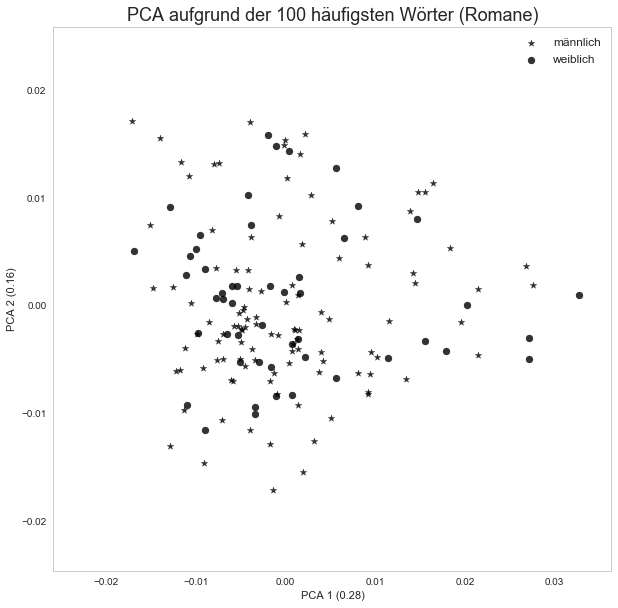

In [78]:
dir_ = r"\mydata\Dropbox\uni\Romangeschichte\romankorpus\data"
meta = pd.read_csv(dir_ + os.sep + "romane kernkorpus.csv", encoding="cp1252", sep=";")
meta.Datei = meta.Datei.str.replace('__', '_')
novels1 = meta.Datei[meta.Jahr > 1799]  
novels2 = meta.Datei[meta.Jahr < 1880]  
novels = set(novels1).intersection(set(novels2))

y = []
for i in novels:
    if (meta.Geschlecht[meta.Datei == i]).item() == "m": 
        y.append(0)
    elif (meta.Geschlecht[meta.Datei == i]).item() == "f":         
        y.append(1)
    else:
        y.append(2)
y = np.array(y)
z = list(y)
print("Männer: {}, Frauen: {}, Insgesamt: {}".format(z.count(0), z.count(1), len(z)))
        
pca = PCA(n_components=2).fit(data)
X_r = pca.transform(data)

plt.figure( figsize =( 10, 10)) 

colors = ['navy', 'darkorange']
labels = ["männlich", "weiblich"]
marker_ = ["*", "o"]


for (i, color, label, marker) in zip([0, 1], colors, labels, marker_):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color="black", alpha=.8, label=label, marker=marker)  


plt.xlabel("PCA 1 ({:.2f})".format(pca.explained_variance_ratio_[0].item()))
plt.ylabel("PCA 2 ({:.2f})".format(pca.explained_variance_ratio_[1].item()))
plt.legend(loc='best', shadow=False, scatterpoints=1, fontsize=12)
plt.title("PCA aufgrund der {} häufigsten Wörter (Romane)".format(now), fontsize=18)
plt.savefig("pca_novels.png", dpi=1200)
plt.show()



Wie verhalten sich die mfw der Romane zu denen der Novellen?

In [24]:
len(set(mfw_novellas).intersection(set(mfw_novels)))

91

Ganz gleichgültig, ob das Zustandekommen der Gruppen nun durch die Auswahl der Herausgeber oder durch Unterschiede im Schreibverhalten bedingt ist, so kann man zur Klärung der Frage, was die beiden Gruppen unterscheidet, auch die loadings der Komponenten heranziehen: 

In [25]:
pca_1 = pd.Series(pca.components_[0], index=data.columns)
pca_2 = pd.Series(pca.components_[1], index=data.columns)
#data.columns
print("Wichtigste Wörter der 1. Komponente:\n{}".format(pca_1.sort_values(ascending=False)[:10]))
print("\nWichtigste Wörter der 2. Komponente:\n{}".format(pca_2.sort_values(ascending=False)[:10]))


Wichtigste Wörter der 1. Komponente:
ich      0.653492
mich     0.275988
mir      0.239721
Ich      0.175930
sie      0.141041
Sie      0.131190
nicht    0.111693
es       0.109137
meine    0.098394
so       0.072594
dtype: float64

Wichtigste Wörter der 2. Komponente:
und     0.777975
ich     0.273384
der     0.119463
mir     0.102488
in      0.100752
mich    0.093371
den     0.065522
die     0.057718
dem     0.044476
wir     0.040302
dtype: float64


Was die erste Komponente ausmacht, ist es ausgesprochen schwer, festzulegen, was der entscheidende Faktor für diese Verteilung ist. Die zweite Komponente dagegen enthält eine ganze Reihe von Worten, die in die gleiche Richtung weisen: sie, ihr, Sie, ihre - alles Worte, die auf Frauen verweisen. Wenn die Pronomina so stark auf Frauen verweisen, dann spricht das dafür, dass Frauen die Hauptfiguren sind? 

In [26]:
def prepare_biblio(metadata):
    # create 2 lists for author name and titles respectively
    # all 4 lists are aligned by the position of the list index
    authors = []
    titles = []
    for z in list(metadata.Datei):
        a, *b = z.split("_")
        authors.append(a)
        titles.append(b[0][:-4])
    return (authors, titles)


def create_hoover_data(x, y, authors, titles):
    # create container for the hover data
    return bp.ColumnDataSource(
        data=dict(
            x=x,
            y=y,
            authors=authors,
            titles=titles,
        )
    )


def prepare_viz(fig_title):
    # defines set of tools at the top of the window
    TOOLS = "pan,wheel_zoom,box_zoom,reset,save, resize, hover"

    # data, x,y are the pca reduced data points
    x = X_r[:, 0]
    y = X_r[:, 1]
    authors, titles = prepare_biblio(metadata)
    source = create_hoover_data(x, y, authors, titles)

    # creates the plot
    p = bp.figure(title=fig_title,
               tools=TOOLS,
               plot_width=1000,
               plot_height=700)

    # paints the data points
    # p.circle(x_coord_specials, y_coord_specials, radius=0.4, fill_alpha=1,   line_color=None, color="red")
    p.circle(x, y, source=source, radius=0.00025, fill_alpha=0.8, line_color=None)

    # get a handle on the hover tool
    hover = p.select(dict(type=bokeh.models.HoverTool))
    # defines the tooltip info displayed via mouse over
    hover.tooltips = [
        ("A", "@authors"),
        ("T", "@titles"),
    ]
    return p

In [27]:
#########################
# main
bp.output_notebook()
now = 100
data = pd.read_csv("corpus_words.csv", index_col=0)[0:now].T
metadata = pd.read_excel("novellen2.xlsx")
#metadata.sort_values(metadata.Datei)

pca = PCA(n_components=2).fit(data)
X_r = pca.transform(data)

p = prepare_viz("Der Novellenschatz")
bp.show(p)

Loading BokehJS ...

C:\WinPython-3.4.4\python-3.4.4.amd64\lib\site-packages\bokeh\util\deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)
C:\WinPython-3.4.4\python-3.4.4.amd64\lib\site-packages\bokeh\util\deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)


Eine mögliche Interpretation dieser Verteilung wäre eine Differenz in der Menge des Dialogs in den Texten. Das lässt sich aber zur Zeit nicht überprüfen, da die direkte Rede in den Texten nicht ausgezeichnet ist. Eine weitere These würde in der Menge der verwendeten Adjektive bestehen.
[Dank an Claudia Stockinger für den Hinweis auf die Möglichkeit, dass ein mehr beschreibender Erzählstil dieser Verteilung zugrundeliegen könnte.]

In [28]:
metadata = pd.read_excel("novellen2.xlsx")
def get_adj(data):
    """calculate number of adjectives as percentage of all tokens of the text"""
    return (len(data.Token[data.POS=="ADJA"]) + len(data.Token[data.POS=="ADJD"])) / len(data)

m_adj = []
w_adj = []


for file in glob.glob("data" + os.sep + "*.csv"):
    data = pd.read_csv(file, encoding="cp1252", sep="\t", index_col=False, quoting=csv.QUOTE_NONE)
    
    
    i = os.path.basename(file)[:-4]

    if (metadata.Geschlecht[metadata.Datei == i]).item() == "m":
        m_adj.append(get_adj(data))
    else:
        w_adj.append(get_adj(data))

print("Männliche Autoren (mean): {}".format(statistics.mean(m_adj)))
print("Männliche Autoren (std): {}".format(statistics.stdev(m_adj)))     
print("Weibliche Autoren (mean) {}".format(statistics.mean(w_adj)))      
print("Weibliche Autoren (std): {}".format(statistics.stdev(w_adj)))      

        


C:\WinPython-3.4.4\python-3.4.4.amd64\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Männliche Autoren (mean): 0.07678123880434255
Männliche Autoren (std): 0.01300813937257772
Weibliche Autoren (mean) 0.07828299267295889
Weibliche Autoren (std): 0.012091410500474232


Der Gebrauch von Adjektiven beim Durchschnitt der weiblichen Autoren ist nicht intensiver als beim Durchschnitt der Männern. 

## Test: Besteht der wesentliche Unterschied darin, dass die Hauptfiguren Frauen sind?

Im Folgenden werden die Namen der zwei wichtigsten Hauptfiguren der Novellen extrahiert, dann wird Ihnen ein Geschlecht zugeordnet (manuell, da automatisch auf die Schnelle nicht lösbar) und es wird so festgelegt, ob die Hauptfigur des Textes eine Frau ist.

In [41]:
infile = r"data\\Keller,-Gottfried_Romeo-und-Julia-auf-dem-Dorfe.txt.csv"
data = pd.read_table(infile, 
                     encoding="cp1252", 
                     index_col=False, 
                     quoting=csv.QUOTE_NONE,
                     na_values=["-","null"],
                    )

data = fix_table(data)  #bug fixing
data.head(10)

,SectionId,ParagraphId,SentenceId,TokenId,Begin,End,Token,Lemma,CPOS,POS,Morphology,DependencyHead,DependencyRelation,NamedEntity,CorefId
0,NaN,0.0,0,0,0,6,?Romeo,?romeo,N,NE,||,würde,SB,O,-1.0
1,NaN,0.0,0,1,7,10,und,und,CONJ,KON,||,?Romeo,CD,O,-1.0
2,NaN,0.0,0,2,11,16,Julia,Julia,N,NE,||,und,CJ,B-PER_CORE,0.0
3,NaN,0.0,0,3,17,20,auf,auf,APPR,APPR,||,erzählen,MO,O,-1.0
4,NaN,0.0,0,4,21,24,dem,der,ART,ART,neut|sg|,Dorfe,NK,O,-1.0
5,NaN,0.0,0,5,25,30,Dorfe,Dorf,N,NN,neut|sg|,auf,NK,O,-1.0
6,NaN,1.0,0,6,32,41,Gottfried,Gottfried,N,NE,neut|sg|,Dorfe,NK,O,-1.0
7,NaN,1.0,0,7,42,48,Keller,Keller,N,NN,neut|pl|,erzählen,CP,O,-1.0
8,NaN,2.0,0,8,52,57,Diese,dieser,PRO,PDAT,neut|pl|,Geschichte,NK,O,-1.0
9,NaN,2.0,0,9,58,68,Geschichte,Geschichte,N,NN,neut|pl|,erzählen,OA,O,-1.0


In [42]:
data = data[data.CorefId != -1]
df = pd.DataFrame([data.Token, data.NamedEntity, data.CorefId]).T
df.head()


,Token,NamedEntity,CorefId
2,Julia,B-PER_CORE,0
20,sie,B-PER_PRON,0
62,sie,B-PER_PRON,0
83,der,B-PER_PRON,1
89,Seldwyl,B-PER_CORE,13


In [43]:
cnt = collections.Counter(df.CorefId)
#get the 2 main characters
chars = cnt.most_common(5)

In [44]:
def identify_char_gender(char_descriptors):
    m_weight = 0
    f_weight = 0
    m_identifier = ['er', 'sein', 'ihm', 'herr', 'herren', 'seine', 'seinem', 'seiner', 'gemahl', 'sohn', 'oberst',
                    'major', 'sergeant', 'vater', 'freund']
    f_identifier = ['sie', 'ihr', 'ihre', 'frau', 'frauen', 'fräulein', 'ehefrau', 'eheweib', 'gemahlin', 'tochter', 
                    'freundin']
    
    names = {}
    names_file = r"..\..\romankorpus\data\nlp\vornamen_einfach.txt"
    
    with open(names_file, encoding="utf-8") as fin:
        for line in fin:
            a, b = line [:-1].split(";")
            names[a] = b

    for c in char_descriptors:
        if c not in m_identifier and c not in f_identifier:
            if c in names.keys():
                if names[c] == "F":
                    f_weight +=2
                elif names[c] == "M":
                    m_weight +=2                    
    
    for id in m_identifier:
        if id in char_descriptors:
            m_weight +=1

    for id in f_identifier:
        if id in char_descriptors:
            f_weight +=1
    #print("m: {} - f:{}".format(m_weight, f_weight))
    if f_weight > m_weight:
        return "f"
    else:
        return "m"



In [45]:
for i in chars:    
#get the best string representing these characters
    char_descriptors_ = set(list(df.Token[df.CorefId == i[0]]))
    char_descriptors  = [s.lower() for s in char_descriptors_]
    print(char_descriptors)

    print("vote: {}".format(identify_char_gender(char_descriptors)))

['ihm', 'seinem', 'sein', 'seinen', 'welchem', "sali's", 'seiner', 'sali', 'seine', 'der', 'ihn', 'seines', 'die', 'manz', 'er', 'er', 'sich', 'seine', 'welche', 'sein']
vote: m
['sie', 'frau', 'liebhaber', 'ihr', 'ihren', 'großvater', 'vreneli', 'dessen', 'welche', 'vrenggel', 'sich', 'vrenchens', 'ihrer', 'vrenchen', 'ihm', 'der', 'ihre', 'aecker', 'ihn', 'sie', 'ihr', 'welchen', 'ihrem']
vote: f
['seinem', 'sie', 'seine', 'frau', 'er', 'ihres', 'ihren', 'welche', 'vater', 'dem', 'er', 'sich', 'vaters', 'ihrer', 'ihm', 'welcher', 'manzens', 'der', 'ihre', 'seiner', 'manz', 'ihn', 'sie', 'ihr', 'welchen', 'ihrem']
vote: m
['ihm', 'seinem', 'seinen', "marti's", 'seiner', 'seine', 'der', 'ihn', 'seines', 'er', 'sich', 'er', 'marti', 'sein']
vote: m
['mich', 'meines', 'mein', 'ich', 'meine', 'mir', 'meinen', 'mich', 'ich', 'meinem', 'mein']
vote: m


Im folgenden wenden wir das auf alle Novellen an, so dass wir das Geschlecht der drei wichtigsten Hauptfiguren einsammeln können. 

In [46]:
main_chars = {}
for infile in glob.glob("data" + os.sep + "*.csv"):
    print(".", end="")
    text_chars = []  #holds gender of the main chars    

    data = pd.read_table(infile, 
                         encoding="cp1252", 
                         index_col=False, 
                         quoting=csv.QUOTE_NONE,
                         na_values=["-","null"],
                        )
    data = fix_table(data)  #bug fixing    
    data = data[data.CorefId != -1]
    df = pd.DataFrame([data.Token, data.NamedEntity, data.CorefId]).T
    
    cnt = collections.Counter(df.CorefId)   
    #get the 3 main characters
    chars = cnt.most_common(3)
    for i in chars:    
        char_descriptors_ = set(list(df.Token[df.CorefId == i[0]]))
        char_descriptors  = [s.lower() for s in char_descriptors_]
        text_chars.append(identify_char_gender(char_descriptors))
    main_chars[os.path.basename(infile)[:-4]] = text_chars
    

.......................................................................................

In [47]:
main_chars["Eichendorff,-Joseph-von_Die-Gluecksritter.txt"]

['m', 'f', 'm']

In [48]:
now = 100
data = pd.read_csv("corpus_words.csv", index_col=0)[0:now].T
metadata = pd.read_excel("novellen2.xlsx")
#mfw_novellas = data.columns
pca = PCA(n_components=2).fit(data)
X_r = pca.transform(data)



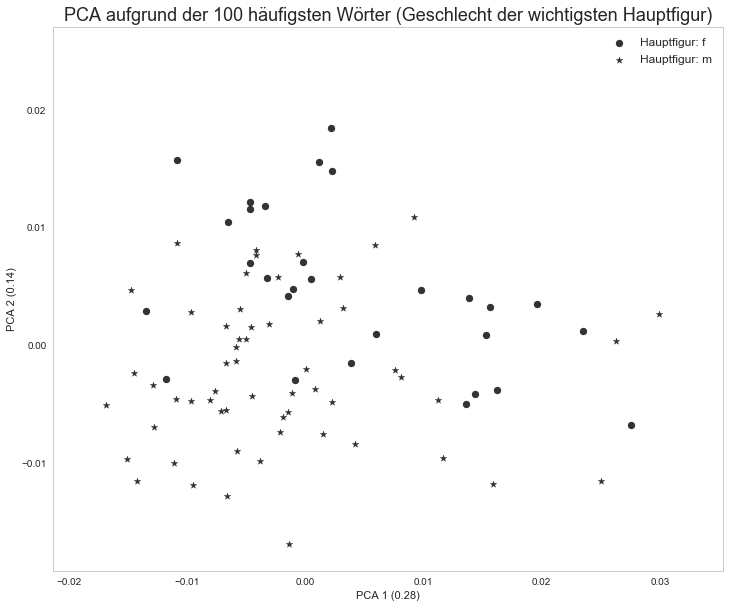

In [72]:
sns.set_style("whitegrid", {'axes.grid' : False})
y = []
for i in data.index:
    if main_chars[i][0] == "f":
        y.append(0)
    elif main_chars[i][0] == "m":
        y.append(1)
y = np.array(y)
        
        
plt.figure( figsize =( 12, 10)) 

colors = ['darkorange', 'navy']
labels = ["Hauptfigur: f", "Hauptfigur: m"]
marker_ = ["o", "*"]


for (i, color, label, marker) in zip([0, 1], colors, labels, marker_):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color="black", alpha=.8, label=label, marker=marker)  


plt.xlabel("PCA 1 ({:.2f})".format(pca.explained_variance_ratio_[0].item()))
plt.ylabel("PCA 2 ({:.2f})".format(pca.explained_variance_ratio_[1].item()))
plt.legend(loc='best', shadow=False, scatterpoints=1, fontsize=12)
plt.title("PCA aufgrund der {} häufigsten Wörter (Geschlecht der wichtigsten Hauptfigur)".format(now), fontsize=18)
plt.savefig("pca gender main char.png", dpi=1200)
plt.show()

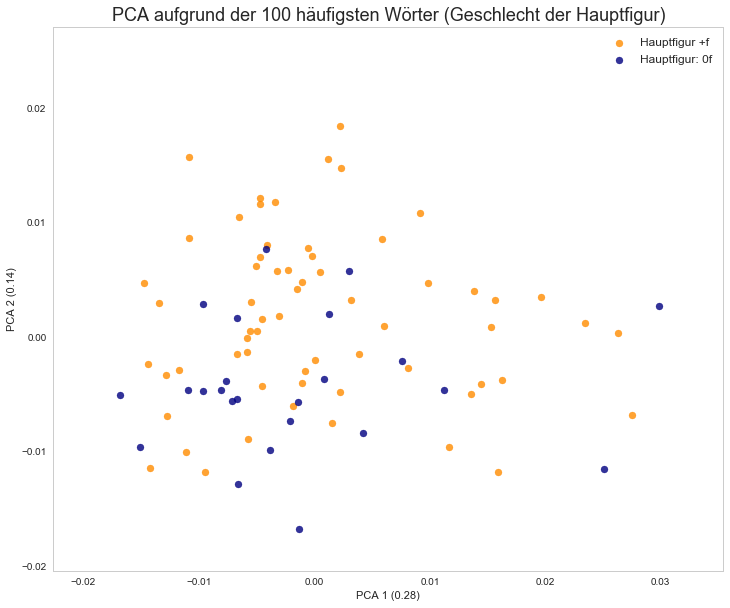

In [50]:
y = []
for i in data.index:
    if "f" in main_chars[i]:
        y.append(0)
    else:
        y.append(1)
y = np.array(y)
        
        
plt.figure( figsize =( 12, 10)) 

colors = ['darkorange', 'navy']
labels = ["Hauptfigur +f", "Hauptfigur: 0f"]


for (i, color, label) in zip([0, 1], colors, labels):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, label=label)  


plt.xlabel("PCA 1 ({:.2f})".format(pca.explained_variance_ratio_[0].item()))
plt.ylabel("PCA 2 ({:.2f})".format(pca.explained_variance_ratio_[1].item()))
plt.legend(loc='best', shadow=False, scatterpoints=1, fontsize=12)
plt.title("PCA aufgrund der {} häufigsten Wörter (Geschlecht der Hauptfigur)".format(now), fontsize=18)
plt.show()

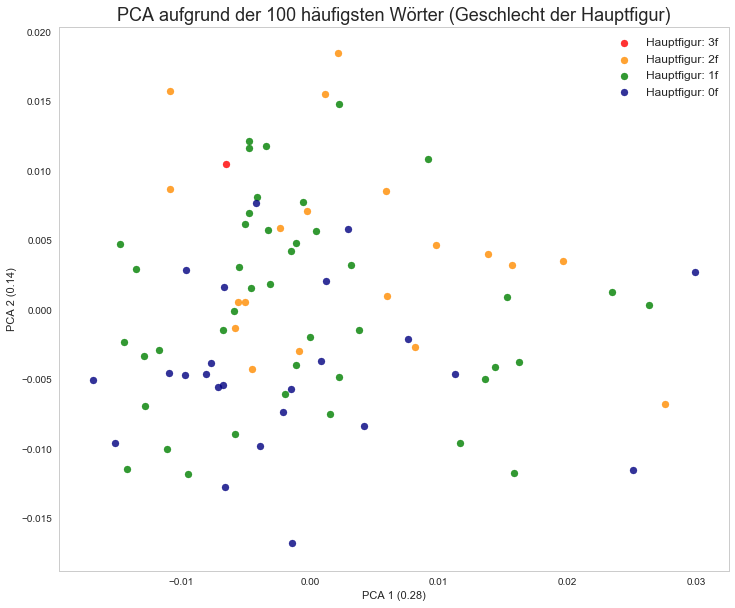

In [51]:

y = []
for i in data.index:
    if main_chars[i].count("f") == 3:
        y.append(0)
    elif main_chars[i].count("f") == 2:
        y.append(1)
    elif main_chars[i].count("f") == 1:
        y.append(2)
    elif main_chars[i].count("f") == 0:        
        y.append(3)
y = np.array(y)
        
        
plt.figure( figsize =( 12, 10)) 

colors = ['red', 'darkorange', 'green', 'navy']
labels = ["Hauptfigur: 3f", "Hauptfigur: 2f", "Hauptfigur: 1f", "Hauptfigur: 0f"]


for (i, color, label) in zip([0, 1, 2, 3], colors, labels):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, label=label)  


plt.xlabel("PCA 1 ({:.2f})".format(pca.explained_variance_ratio_[0].item()))
plt.ylabel("PCA 2 ({:.2f})".format(pca.explained_variance_ratio_[1].item()))
plt.legend(loc='best', shadow=False, scatterpoints=1, fontsize=12)
plt.title("PCA aufgrund der {} häufigsten Wörter (Geschlecht der Hauptfigur)".format(now), fontsize=18)
plt.show()

Im Folgenden definieren wir als das Vorhandensein einer weiblichen Hauptfigur, die Fälle, in denen die wichtigste oder zweitwichtigste Figur weiblich ist.

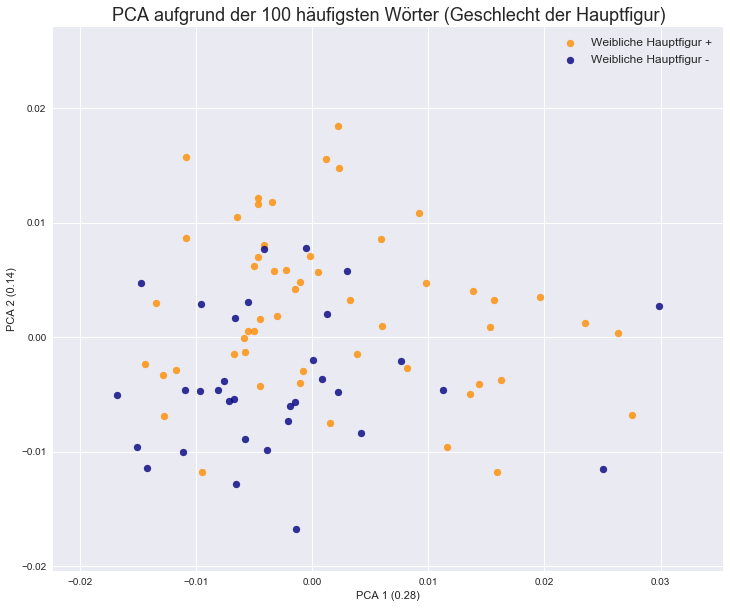

In [34]:
y = []
for i in data.index:
    if main_chars[i][0] == "f" or main_chars[i][1] == "f":
        y.append(0)
    else:
        y.append(1)
y = np.array(y)
        
        
plt.figure( figsize =( 12, 10)) 

colors = ['darkorange', 'navy']
labels = ["Weibliche Hauptfigur +", "Weibliche Hauptfigur -"]


for (i, color, label) in zip([0, 1, 2, 3], colors, labels):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, label=label)  


plt.xlabel("PCA 1 ({:.2f})".format(pca.explained_variance_ratio_[0].item()))
plt.ylabel("PCA 2 ({:.2f})".format(pca.explained_variance_ratio_[1].item()))
plt.legend(loc='best', shadow=False, scatterpoints=1, fontsize=12)
plt.title("PCA aufgrund der {} häufigsten Wörter (Geschlecht der Hauptfigur)".format(now), fontsize=18)
plt.show()

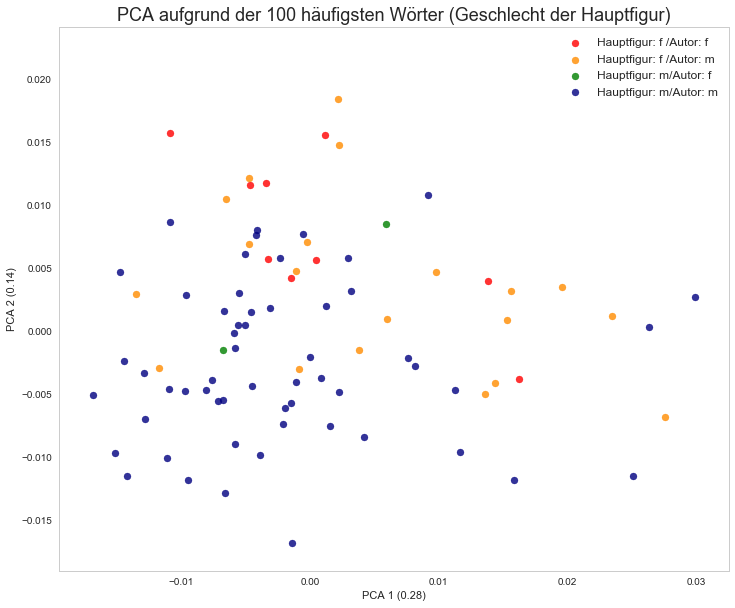

In [17]:
y = []
for i in data.index:
    if main_chars[i][0] == "f":
        if (metadata.Geschlecht[metadata.Datei == i]).item() == "w":         
            y.append(0)
        else: 
            y.append(1)
    elif main_chars[i][0] == "m":
        if (metadata.Geschlecht[metadata.Datei == i]).item() == "w":         
            y.append(2)
        else: 
            y.append(3)

y = np.array(y)
        
        
plt.figure( figsize =( 12, 10)) 

colors = ['red', 'darkorange', 'green', 'navy']
labels = ["Hauptfigur: f /Autor: f", "Hauptfigur: f /Autor: m", "Hauptfigur: m/Autor: f", "Hauptfigur: m/Autor: m"]


for (i, color, label) in zip([0, 1, 2, 3], colors, labels):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, label=label)  


plt.xlabel("PCA 1 ({:.2f})".format(pca.explained_variance_ratio_[0].item()))
plt.ylabel("PCA 2 ({:.2f})".format(pca.explained_variance_ratio_[1].item()))
plt.legend(loc='best', shadow=False, scatterpoints=1, fontsize=12)
plt.title("PCA aufgrund der {} häufigsten Wörter (Geschlecht der Hauptfigur)".format(now), fontsize=18)
plt.show()

In [18]:
X_r[:5]

array([[-0.00712898, -0.00552732],
       [ 0.01587   , -0.01172857],
       [-0.00305092,  0.00186285],
       [-0.00961224,  0.00290246],
       [-0.00468551,  0.01217116]])

In [32]:
now = 100
data = pd.read_csv("corpus_words.csv", index_col=0)[0:now].T
metadata = pd.read_excel("novellen2.xlsx")
mfw_novellas = data.columns


## Charakteristische Worte für die Hauptkomponenten
Mit Zeta kann man die charakteristischen Worte für eine Textgruppe im Gegensatz zu einer anderen Textgruppe ermitteln. Im folgenden verwende ich die Implementierung von Christof Schöch, um Zeta für die Texte mit einem hohen Wert für die Hauptkomponente 2 vs. einem niedrigen Wert zu bestimmen. Im Prinzip werden die Dateien, die einen Wert über 0.004 haben den Dateien gegenübergestellt, die einen Wert 

In [35]:
#preparing data for stylo's zeta (which seems to be broken atm)
df = pd.DataFrame(X_r, index=data.index, columns=["pca1", "pca2"])
for f in df[df.pca2 > 0.004].index:
    shutil.copy("corpus\\" + f, "primary_set")

for f in df[df.pca2 < 0.004].index:
    shutil.copy("corpus\\" + f, "secondary_set")

    #len(metadata.Autor[metadata.Geschlecht == "w"])

In [39]:
df = pd.DataFrame(X_r, index=data.index, columns=["pca1", "pca2"])
#preparing data for pyzeta, (idno is filename without file extension!)
with open("zeta_meta.csv", "w", encoding="utf-8") as fout:
    fout.write("{};{}\n".format("idno", "value"))
    for f in df[df.pca2 > 0.004].index:
        fout.write("{};{}\n".format(f[:-4], "high_values"))

    for f in df[df.pca2 < -0.004].index:
        fout.write("{};{}\n".format(f[:-4], "low_values"))


In [40]:
import pyzeta   # see https://github.com/cligs/pyzeta, this cell is the main bulk of run_zeta.py  
seglength = 1000  # int; 1000|2000|5000 are reasonable
pos = "all"  # Nc|Vv|Rg|Ag etc. depending on tagger model, or "all" if no selection
forms = "lemmata"  # words|lemmata|pos
contrast = ["value", "high_value", "low_value"]  # category, label1, label2
workdir = r"." + os.sep  # full path to working directory; ends with slash
plaintextfolder = os.path.join(workdir, "corpus", "")
metadatafile = os.path.join(workdir, "zeta_meta.csv")
stoplistfile = os.path.join(workdir, "de2.txt")
taggedfolder = os.path.join(workdir, "tagged", "")
datafolder = os.path.join(workdir, "data2", "")
resultsfolder = os.path.join(workdir, "results", "")
contraststring = contrast[1] + "-" + contrast[2]
parameterstring = str(seglength) + "-" + forms + "-" + str(pos)


# =================================
# Functions
# =================================

# Prepare texts: tag and save (run once for a collection).
language = "de"  # TreeTagger language model code
#pyzeta.prepare(plaintextfolder, language, taggedfolder)


# Calculate Zeta for words in two text collections
pyzeta.zeta(taggedfolder, metadatafile, contrast, datafolder, resultsfolder,
            seglength, pos, forms, stoplistfile)


# Barchart with the most extreme zeta values
numfeatures = 25
pyzeta.plot_zetascores(numfeatures, contrast, contraststring, parameterstring, resultsfolder)


# Scatterplot of types
numfeatures = 200  # int
cutoff = 0.40
pyzeta.plot_types(numfeatures, cutoff, contrast, contraststring, parameterstring, resultsfolder)


--make_filelist
----number of texts: 0 and 0
--read_stoplistfile
--make_segments


ValueError: No objects to concatenate

## todo
- t-Test ob der Unterschied zwischen weibl. / männl. Figuren signifikant ist
- Ancova der gleichen Verteilung; bessere Überprüfung
- Pyzeta mit den Texten, sowohl auf der 1. wie der 2. Hauptkomponente. Analyse der Worte, um zu verstehn, was die 1. Komponente ist. Bestätigung/Widerlegung der These für die 2. Auswahl der Texte aufgrund ihrer PCA-Werte
- Weiterarbeit am Abschnitt über die Vorbilder: Welche andere Faktoren könnten zu einer größeren stilistischen Nähe führen? 
- Ein solcher Faktor ist die Unterscheidung zwischen homodiegetischem und heterodiegetischem Erzählen. Versuchen, diesen automatisch zu erheben.




# Material

In [138]:
## Bugsearch and fixing cell: ignore

#metadata = pd.read_csv("novellen3.csv", sep=";", encoding="cp1252")
metadata = pd.read_excel("novellen2.xlsx")
d = np.array(["Alexis,_Willibald-Herr_von_Sacken.txt", "Geothe"])

data = pd.read_csv("corpus_words.csv", index_col=0)[0:now].T
#metadata = pd.read_excel("novellen2.xlsx")

y = []
for i in data.index:
    if (metadata.Jahr[metadata.Datei == i]).item() < 1849: 
        y.append(0)
    else:
        y.append(1)
y = np.array(y)

j = ['c:\\Alexis,-Willibald_Herr-von-Sacken.txt', 'c:\\Andolt,-Ernst_Eine-Nacht.txt',
       'c:\\Arnim,-Achim-von_Der-tolle-invalide-auf-dem-Fort-Ratonneau.txt']
j2 = ['Alexis,-Willibald_Herr-von-Sacken.txt', 'Andolt,-Ernst_Eine-Nacht.txt',
       'Arnim,-Achim-von_Der-tolle-invalide-auf-dem-Fort-Ratonneau.txt']

for i in j2:
    i = os.path.basename(i)
    print(i)
    if (metadata.Jahr[metadata.Datei == i]).item() < 1830: 
        print("j: " + i)
    if (metadata.Geschlecht[metadata.Datei == i]).item() == "m":
        print("g:" + i)

    if (metadata.Geschlecht[metadata.Datei == i]).item() == "m":
        print("hello")

for i in j2:
    if (metadata.Geschlecht[metadata.Datei == i]).item() == "m":
        print(i)

Alexis,-Willibald_Herr-von-Sacken.txt
g:Alexis,-Willibald_Herr-von-Sacken.txt
hello
Andolt,-Ernst_Eine-Nacht.txt
g:Andolt,-Ernst_Eine-Nacht.txt
hello
Arnim,-Achim-von_Der-tolle-invalide-auf-dem-Fort-Ratonneau.txt
j: Arnim,-Achim-von_Der-tolle-invalide-auf-dem-Fort-Ratonneau.txt
g:Arnim,-Achim-von_Der-tolle-invalide-auf-dem-Fort-Ratonneau.txt
hello
Alexis,-Willibald_Herr-von-Sacken.txt
Andolt,-Ernst_Eine-Nacht.txt
Arnim,-Achim-von_Der-tolle-invalide-auf-dem-Fort-Ratonneau.txt


## Erzählungen aus Textgrid

In [42]:
#Liste mit den Datei/Text-Informationen 
files = []
c = 0
def parse_filename(filename):
    (title, id, suffix) = filename.split(".") 
    return (title, id, suffix)
for name in os.listdir(narr_dir):
    for genre in os.listdir(narr_dir + os.sep + name):
        for text in os.listdir(narr_dir + os.sep + name + os.sep + genre):
            (title, id, suffix) = parse_filename(text)
            t = Text(name, title)
            t.tgid = id
            t.filename = name + os.sep + genre + os.sep + text
            t.genre = genre
            files.append(t)
            
print("Number of files: ", len(files))    
print(files[0])
        

FileNotFoundError: [WinError 3] Das System kann den angegebenen Pfad nicht finden: '\\mydata\\owncloud\\projekt romangeschichte\\Erzählungen\\erzaehlungen'

In [182]:
for f in files:
    with open(narr_dir + os.sep + f.filename, encoding="utf-8") as fin: 
        toks = 0
        for line in fin:
            toks += len(re.findall("\w+", line))
        f.tokens = toks
            

In [187]:
cnt = 0
for f in files:
    if f.tokens > 5000:
        cnt += 1
        shutil.copy(narr_dir + os.sep + f.filename, r"D:\mydata\Dropbox\uni\Romangeschichte\labor\novellen2\corpus2" + 
                    os.sep + os.path.basename(f.filename))
print(cnt)

574


In [ ]:
print(files[0])
files[0].tokens


In [ ]:
with open("tg_erzaehlungen.csv", "w", encoding="utf-8") as fout:
    for f in files:
        if f.tokens > 5000:
            s = "{0};{1};{2};{3}".format(f.author, f.title, f.genre, f.filename)
            fout.write(s + "\n")


In [ ]:
genres = Counter()
for f in files:
        if f.tokens > 5000:
           genres[f.genre] += 1
xvals = []
yvals = []
for x,y in sorted(genres.items()):
    xvals.append(x) 
    yvals.append(y)
f, ax = plt.subplots(figsize=(16, 5))    
sns.barplot(yvals, xvals, palette="BuGn_d")
plt.title("Verteilung der Gattungen von Prosatexten mit mehr als 5.000 Wörtern")
plt.plot()

### Exkurs: Splitting Boccaccio

"""
fin = open(narr_dir + os.sep + r"Boccaccio, Giovanni\Novellensammlung\Das_Dekameron.tg4.txt", encoding="utf-8")
t = ["Erster", "Zweiter", "Dritter", "Vierter", "Fünfter", "Sechster", "Siebenter", "Achter", "Neunter", "Zehnter", ""]
buffer = ""
day = ""
#split into days
for line in fin:
    if t[0]+" Tag\n" in line or line=="":
        with open("boccaccio" + os.sep + day + "_Tag.txt", "w", encoding="utf-8") as fout:
            fout.write(buffer)
        buffer=line
        day = t.pop(0)
    else:
        buffer += line

with open("boccaccio" + os.sep + day + "_Tag.txt", "w", encoding="utf-8") as fout:
    fout.write(buffer)
"""        

"""
t = ["Erster", "Zweiter", "Dritter", "Vierter", "Fünfter", "Sechster", "Siebenter", "Achter", "Neunter", "Zehnter"]
g = ["", "Erste", "Zweite", "Dritte", "Vierte", "Fünfte", "Sechste", "Siebente", "Achte", "Neunte", "Zehnte", "", ""]
buffer = ""
story = ""
cnt = 0
cnt_d = 1
for i in t:
    fin = open(r"boccaccio\\" + i + "_Tag.txt", encoding="utf-8")
    for line in fin:
        if g[cnt+1]+" Geschichte\n" in line:
            with open("boccaccio" + os.sep + str(cnt_d) + "-" +  str(cnt) +".txt", "w", encoding="utf-8") as fout:
                fout.write(buffer)
            buffer=""
            cnt += 1
        else:
            buffer += line


    with open("boccaccio" + os.sep + str(cnt_d) + "-" + str(cnt) +".txt", "w", encoding="utf-8") as fout:
        fout.write(buffer)
    fin.close()
    cnt_d += 1
    cnt = 0
    buffer = ""
"""        

### Exkurs: Novellenschatz preprocessing

Treetagger

In [3]:
import treetaggerwrapper
import glob
import os
tagger = treetaggerwrapper.TreeTagger(TAGLANG='de')
for file in glob.glob("corpus\\*.txt"):
    with open(file, encoding="utf-8") as fin:
        with open("tagged\\" + os.path.basename(file[:-4]+".csv"), "w", encoding="utf-8") as fout:
            for line in fin:
                for token in tagger.tag_text(line):
                    fout.write("{}\n".format(token))

Schreibe die Novellendateien so, dass sie den Nachnamen und die Jahreszahl enthalten.

In [79]:
metadata = pd.read_excel("novellen2.xlsx")
metadata.head()

,Autor,Titel,Jahr,Geschlecht,Geburt,Tod,Kanon,Datei
0,Willibald Alexis,Herr von Sacken,1837,m,1798-06-29,1871-12-16,j,"Alexis,-Willibald_Herr-von-Sacken.txt"
1,Ernst Andolt,Eine Nacht,1857,m,1826-03-27,1901-04-01 00:00:00,n,"Andolt,-Ernst_Eine-Nacht.txt"
2,Achim von Arnim,Der tolle Invalide auf dem Fort Ratonneau,1818,m,1831-01-21,1871-01-26,j,"Arnim,-Achim-von_Der-tolle-invalide-auf-dem-Fo..."
3,Berthold Auerbach,Die Geschichte des Diethelm von Buchenberg,1853,m,1812-02-28,1882-02-08,j,"Auerbach,-Berthold_Die-Geschichte-des-Diethelm..."
4,Franz Berthold,Irrwisch-Fritze,1839,m,1800-01-15,1839-02-14,n,"Berthold,-Franz_Irrwisch_Fritze.txt"


In [95]:
indir = "corpus"
outdir = r"D:\mydata\Dropbox\uni\PROJEKT\pydelta\pydelta\corpus2"

def get_year(year):
    """returns decade for a year"""
    year = str(year)
    return year[:3]+"0"

for i in range(len(metadata)):
    *firstname, author = metadata.iloc[i].Autor.split(" ")
    if author == "Droste-Hülshoff":
        author = "Droste"
    filename = "{}_{}.txt".format(get_year(metadata.iloc[i].Jahr), author)
    print(filename)
    shutil.copy(indir + os.sep + metadata.iloc[i].Datei, outdir + os.sep + filename)

1830_Alexis.txt
1850_Andolt.txt
1810_Arnim.txt
1850_Auerbach.txt
1830_Berthold.txt
1350_Boccaccio.txt
1810_Brentano.txt
1810_Chamisso.txt
1870_Dincklage.txt
1860_Droste.txt
1840_Eichendorff.txt
1810_Ense.txt
1860_Frey.txt
1850_Gall.txt
1860_Gerstäcker.txt
1870_Glümer.txt
1800_Goethe.txt
1850_Goldammer.txt
1850_Goldammer.txt
1850_Gotthelf.txt
1850_Gotthelf.txt
1840_Grillparzer.txt
1850_Grimm.txt
1870_Grosse.txt
1860_Hackländer.txt
1870_Halm.txt
1860_Hartmann.txt
1820_Hauff.txt
1840_Heyden.txt
1860_Heyse.txt
1850_Höfer.txt
1820_Hoffmann.txt
1860_Holtei.txt
1870_Horner.txt
1830_Immermann.txt
1810_Kähler.txt
1850_Keller.txt
1840_Kinkel.txt
1840_Kinkel.txt
1810_Kleist.txt
1850_Kompert.txt
1830_Kopisch.txt
1850_Kopisch.txt
1820_Kruse.txt
1850_Kürnberger.txt
1850_Kugler.txt
1850_Kurz.txt
1850_Lewald.txt
1840_Lohmann.txt
1860_Lorm.txt
1860_Ludwig.txt
1850_Meißner.txt
1860_Meyr.txt
1850_Mörike.txt
1850_Mügge.txt
1820_Müller.txt
1860_Pichler.txt
1860_Raabe.txt
1850_Reich.txt
1860_Riehl.txt
1860_